In [1]:
%matplotlib inline


Functional connectivity matrices for group analysis of connectomes
==================================================================

This example compares different kinds of functional connectivity between
regions of interest : correlation, partial correlation, as well as a kind
called **tangent**. The resulting connectivity coefficients are used to
discriminate ADHD patients from healthy controls and the **tangent kind**
**outperforms** the standard connectivity kinds.



In [2]:
# A useful matrix plotting function
import numpy as np
import matplotlib.pylab as plt


def plot_matrices(matrices, matrix_kind):
    n_matrices = len(matrices)
    plt.figure(figsize=(n_matrices * 4, 4))
    for n_subject, matrix in enumerate(matrices):
        plt.subplot(1, n_matrices, n_subject + 1)
        matrix = matrix.copy()  # avoid side effects
        # Set diagonal to zero, for better visualization
        np.fill_diagonal(matrix, 0)
        vmax = np.max(np.abs(matrix))
        plt.imshow(matrix, vmin=-vmax, vmax=vmax, cmap='RdBu_r',
                   interpolation='nearest')
        plt.title('{0}, subject {1}'.format(matrix_kind, n_subject))

Load ADHD dataset and MSDL atlas
--------------------------------
We study only 20 subjects from the ADHD dataset, to save computation time.



In [5]:
from nilearn import datasets

adhd_data = datasets.fetch_adhd(n_subjects=2)

We use probabilistic regions of interest (ROIs) from the MSDL atlas.



In [6]:
msdl_data = datasets.fetch_atlas_msdl()
msdl_coords = msdl_data.region_coords
n_regions = len(msdl_coords)
print('MSDL has {0} ROIs, part of the following networks :\n{1}.'.format(
    n_regions, msdl_data.networks))

MSDL has 39 ROIs, part of the following networks :
[b'Aud', b'Aud', b'Striate', b'DMN', b'DMN', b'DMN', b'DMN', b'Occ post', b'Motor', b'R V Att', b'R V Att', b'R V Att', b'R V Att', b'Basal', b'L V Att', b'L V Att', b'L V Att', b'D Att', b'D Att', b'Vis Sec', b'Vis Sec', b'Vis Sec', b'Salience', b'Salience', b'Salience', b'Temporal', b'Temporal', b'Language', b'Language', b'Language', b'Language', b'Language', b'Cereb', b'Dors PCC', b'Cing-Ins', b'Cing-Ins', b'Cing-Ins', b'Ant IPS', b'Ant IPS'].


Region signals extraction
-------------------------
To extract regions time series, we instantiate a
:class:`nilearn.input_data.NiftiMapsMasker` object and pass the atlas the
file name to it, as well as filtering band-width and detrending option.



In [7]:
from nilearn import input_data

masker = input_data.NiftiMapsMasker(
    msdl_data.maps, resampling_target="data", t_r=2.5, detrend=True,
    low_pass=.1, high_pass=.01, memory='nilearn_cache', memory_level=1)

Then we compute region signals and extract useful phenotypic informations.



In [8]:
adhd_subjects = []
pooled_subjects = []
site_names = []
adhd_labels = []  # 1 if ADHD, 0 if control
for func_file, confound_file, phenotypic in zip(
        adhd_data.func, adhd_data.confounds, adhd_data.phenotypic):
    time_series = masker.fit_transform(func_file, confounds=confound_file)
    pooled_subjects.append(time_series)
    is_adhd = phenotypic['adhd']
    if is_adhd:
        adhd_subjects.append(time_series)

    site_names.append(phenotypic['site'])
    adhd_labels.append(is_adhd)

print('Data has {0} ADHD subjects.'.format(len(adhd_subjects)))

C:\Users\mmenoret\Miniconda2\envs\fmri_3\lib\site-packages\scipy\ndimage\interpolation.py:462: UserWarning: The behaviour of affine_transform with a one-dimensional array supplied for the matrix parameter has changed in scipy 0.18.0.
  "The behaviour of affine_transform with a one-dimensional "


Data has 2 ADHD subjects.


In [11]:
print(adhd_subjects)

[array([[  -0.58246407,   -1.03686171,    3.02527832, ...,   -1.60478415,
          -0.69924974,    1.74144361],
       [   8.76886935,   22.28327575,  163.86765483, ...,  -34.86895439,
         -61.55787388,  -43.82552104],
       [   7.85861825,   46.5584071 ,  229.53085914, ...,  -41.97488978,
        -117.99751934,  -65.51528053],
       ..., 
       [  -8.05866566,  -39.17508772,  -17.75178107, ...,   65.29135729,
         -71.02348089,  131.2429304 ],
       [  10.37863204,  -36.57334776,  -19.56292536, ...,   73.99586205,
         -75.69368491,  104.73170918],
       [   6.81553154,    7.76488876,    5.07357001, ...,    4.08080753,
           7.27173719,   -4.45954109]]), array([[  -7.91987624,   -7.34193039,   11.44812361, ...,    7.0833658 ,
          -3.52718317,   -0.55326663],
       [ 162.21403637,   23.08079628,   63.90882196, ...,  150.06226171,
          63.64675416,   45.71116394],
       [ 177.99266094,   63.33352449,   27.44956442, ...,  193.28188885,
         115.52

ROI-to-ROI correlations of ADHD patients
----------------------------------------
The simpler and most commonly used kind of connectivity is correlation. It
models the full (marginal) connectivity between pairwise ROIs. We can
estimate it using :class:`nilearn.connectome.ConnectivityMeasure`.



In [14]:
from nilearn.connectome import ConnectivityMeasure

correlation_measure = ConnectivityMeasure(kind='correlation')

From the list of ROIs time-series for ADHD subjects, the
`correlation_measure` computes individual correlation matrices.



In [15]:
correlation_matrices = correlation_measure.fit_transform(adhd_subjects)

# All individual coefficients are stacked in a unique 2D matrix.
print('Correlations of ADHD patients are stacked in an array of shape {0}'
      .format(correlation_matrices.shape))

Correlations of ADHD patients are stacked in an array of shape (2, 39, 39)


as well as the average correlation across all fitted subjects.



In [16]:
mean_correlation_matrix = correlation_measure.mean_
print('Mean correlation has shape {0}.'.format(mean_correlation_matrix.shape))

Mean correlation has shape (39, 39).


We display the connectomes of the first 3 ADHD subjects and the mean
correlation matrix over all ADHD patients.



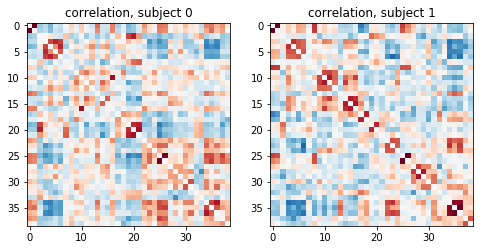

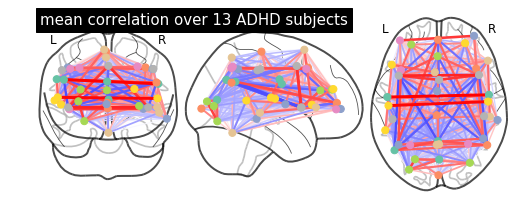

In [17]:
from nilearn import plotting

plot_matrices(correlation_matrices[:4], 'correlation')
plotting.plot_connectome(mean_correlation_matrix, msdl_coords,
                         title='mean correlation over 13 ADHD subjects')

Look at blocks structure, reflecting functional networks.



Examine partial correlations
----------------------------
We can also study **direct connections**, revealed by partial correlation
coefficients. We just change the `ConnectivityMeasure` kind



In [18]:
partial_correlation_measure = ConnectivityMeasure(kind='partial correlation')

and repeat the previous operation.



In [19]:
partial_correlation_matrices = partial_correlation_measure.fit_transform(
    adhd_subjects)

Most of direct connections are weaker than full connections, resulting
in a sparse mean connectome graph.



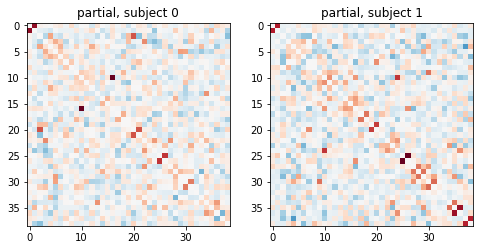

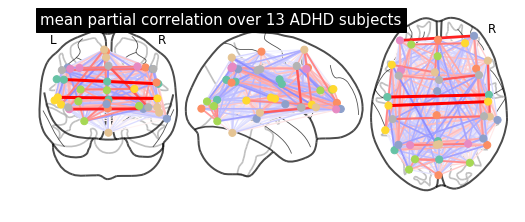

In [20]:
plot_matrices(partial_correlation_matrices[:4], 'partial')
plotting.plot_connectome(
    partial_correlation_measure.mean_, msdl_coords,
    title='mean partial correlation over 13 ADHD subjects')

Extract subjects variabilities around a robust group connectivity
-----------------------------------------------------------------
We can use **both** correlations and partial correlations to capture
reproducible connectivity patterns at the group-level and build a **robust**
**group connectivity matrix**. This is done by the **tangent** kind.



In [22]:
tangent_measure = ConnectivityMeasure(kind='tangent')

We fit our ADHD group and get the group connectivity matrix stored as
in `tangent_measure.mean_`, and individual deviation matrices of each subject
from it.



In [23]:
tangent_matrices = tangent_measure.fit_transform(adhd_subjects)

In [26]:
print(adhd_subjects.shape)
tangent_matrices.shape

AttributeError: 'list' object has no attribute 'shape'

`tangent_matrices` model individual connectivities as
**perturbations** of the group connectivity matrix `tangent_measure.mean_`.
Keep in mind that these subjects-to-group variability matrices do not
straight reflect individual brain connections. For instance negative
coefficients can not be interpreted as anticorrelated regions.



In [13]:
plot_matrices(tangent_matrices[:4], 'tangent variability')
plotting.plot_connectome(
    tangent_measure.mean_, msdl_coords,
    title='mean tangent connectivity over 13 ADHD subjects')

NameError: name 'tangent_matrices' is not defined

The mean connectome graph is not as sparse as partial correlations graph,
yet it is less dense than correlations graph.



What kind of connectivity is most powerful for classification?
--------------------------------------------------------------
*ConnectivityMeasure* can output the estimated subjects coefficients
as a 1D arrays through the parameter *vectorize*.



In [ ]:
connectivity_biomarkers = {}
kinds = ['correlation', 'partial correlation', 'tangent']
for kind in kinds:
    conn_measure = ConnectivityMeasure(kind=kind, vectorize=True)
    connectivity_biomarkers[kind] = conn_measure.fit_transform(pooled_subjects)

# For each kind, all individual coefficients are stacked in a unique 2D matrix.
print('{0} correlation biomarkers for each subject.'.format(
    connectivity_biomarkers['correlation'].shape[1]))

Note that we use the **pooled groups**. This is crucial for **tangent** kind,
to get the displacements from a **unique** `mean_` of all subjects.



We stratify the dataset into homogeneous classes according to phenotypic
and scan site. We then split the subjects into 3 folds with the same
proportion of each class as in the whole cohort



In [ ]:
from sklearn.cross_validation import StratifiedKFold

classes = ['{0}{1}'.format(site_name, adhd_label)
           for site_name, adhd_label in zip(site_names, adhd_labels)]
cv = StratifiedKFold(classes, n_folds=3)

and use the connectivity coefficients to classify ADHD patients vs controls.



In [ ]:
from sklearn.svm import LinearSVC
from sklearn.cross_validation import cross_val_score

mean_scores = []
for kind in kinds:
    svc = LinearSVC(random_state=0)
    cv_scores = cross_val_score(svc, connectivity_biomarkers[kind],
                                y=adhd_labels, cv=cv, scoring='accuracy')
    mean_scores.append(cv_scores.mean())

Finally, we can display the classification scores.



In [ ]:
plt.figure(figsize=(6, 4))
positions = np.arange(len(kinds)) * .1 + .1
plt.barh(positions, mean_scores, align='center', height=.05)
yticks = [kind.replace(' ', '\n') for kind in kinds]
plt.yticks(positions, yticks)
plt.xlabel('Classification accuracy')
plt.grid(True)
plt.tight_layout()

plt.show()